<a href="https://colab.research.google.com/github/teeokh/Bird-Call-Classifier/blob/main/bird_call_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install tensorflow-io
!pip install matplotlib

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
# Define the paths to the files

CAPUCHIN_FILE = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data" ,"Parsed_Capuchinbird_Clips", "XC3776-3.wav")
NON_CAPUCHIN_FILE = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data", "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav")


In [4]:
# Build function to load the data

# Loads and preprocesses the audio to resample into 16k SR, and into mono (1 channel)
def load_wav_16k_mono(filename):

  # Loads contents of audio file. This returns a string (file_contents)
  file_contents = tf.io.read_file(filename)

  # Decodes the audio file string, returning the audio array and the sample rate (decode_wav returns this as a tensor into 2 elements)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

  # Gets rid of trailing axis? And converts sample rate to an integer (so we can resample)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  # Resamples audio array to 16k SR
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

  return wav

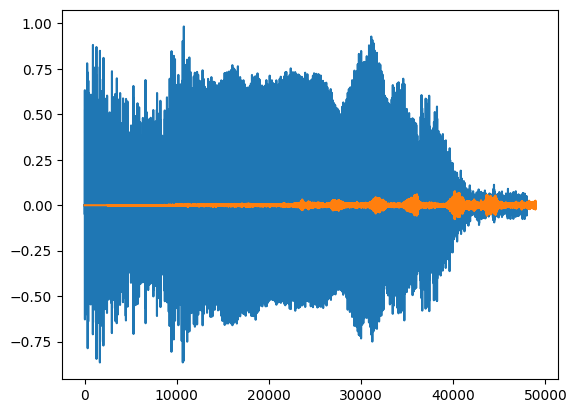

In [5]:
# Plot the waves

wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NON_CAPUCHIN_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
# Define file paths for positive and negative data

POS = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data" ,"Parsed_Capuchinbird_Clips")
NEG = os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data", "Parsed_Not_Capuchinbird_Clips")

In [7]:
# Create Tensorflow datasets for each set of files

pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

data = positives.concatenate(negatives)

In [ ]:
# Loops through each file and collects the length in samples

lengths = []
for file in os.listdir(os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data" ,"Parsed_Capuchinbird_Clips")):
	tensor_wave = load_wav_16k_mono(os.path.join("/content/drive/MyDrive/Datasets/Bird_Call_Data" ,"Parsed_Capuchinbird_Clips", file))
	lengths.append(len(tensor_wave))

lengths

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [10]:
def preprocess (file_path, label):
	wav = load_wav_16k_mono(file_path)
	wav = wav[:48000] # Caps the samples to 48000 length (too long = more time loading)

	zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
	wav = tf.concat([zero_padding, wav],0)
	# If file_path is shorter than 48000, then it fills the rest with 0's

	spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
	spectrogram = tf.abs(spectrogram)
	spectrogram = tf.expand_dims(spectrogram, axis=2)

	return spectrogram, label

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
spectrogram

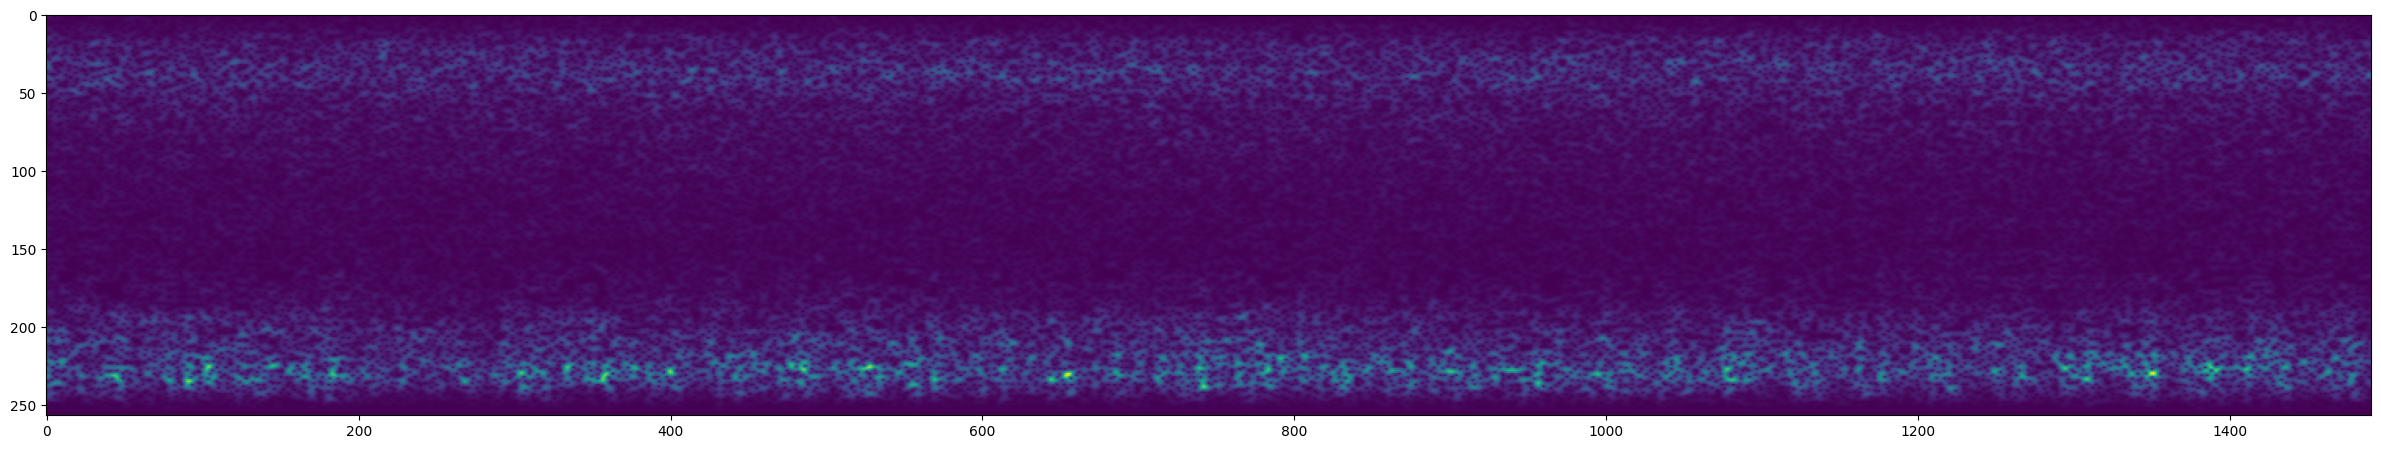

In [11]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [12]:
data = data.map(preprocess) #Runs each file in the data through preprocess to
# create spectrograms
data = data.cache()
data = data.shuffle(buffer_size=1000) # Shuffles data
data = data.batch(16) # Train on 16 examples at a time
data = data.prefetch(8) # Eliminates CPU bottlenecking

In [13]:
training_number = tf.math.round(len(data)*0.7) # Training split = 70% of data
training_number = tf.cast(training_number, tf.int64) # Converts the number to int64 - so it can be used in take and skip

train = data.take(training_number)
test = data.skip(training_number).take((len(data) - training_number))

In [19]:
examples, labels = train.as_numpy_iterator().next()
examples.shape

(16, 1491, 257, 1)

Building deep learning model:

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [15]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation="relu", input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [16]:
model.compile("Adam", loss="BinaryCrossentropy", metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
